In [ ]:
%env CUDA_LAUNCH_BLOCKING=0
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_LAUNCH_BLOCKING=0
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
# Importing data

# !upload kaggle.json to use API for downloading abaw dataset from private repo!
from google.colab import files
files.upload()

# move kaggle key to .kaggle 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install -q kaggle

!kaggle datasets download -d dmitrykozlov10/abaw-lsd --unzip



Saving kaggle.json to kaggle.json
100% 829M/829M [00:44<00:00, 22.0MB/s]
100% 829M/829M [00:44<00:00, 19.5MB/s]


In [1]:
# mark folders

train_dir='training_set_synthetic_images/training_set_synthetic_images'
test_dir='validation_set_real_images/validation_set_real_images'

In [2]:
#!pip install mord

import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score
#import mord

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [3]:
def one_hot_transfer(label,class_num):
    return np.eye(class_num)[label]

def metric_for_Exp(gt,pred,class_num=6):
    # compute_acc
    acc = accuracy_score(gt,pred)
    # compute_F1
    gt = one_hot_transfer(gt,class_num).detach().cpu().numpy()
    pred = one_hot_transfer(pred,class_num).detach().cpu().numpy()
    F1 = []
    for i in range(class_num):
        gt_ = gt[:,i]
        pred_ = pred[:,i]
        F1.append(f1_score(gt_.flatten(), pred_))
    F1_mean = np.mean(F1)
    return F1_mean,acc,F1


# fix seed
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(1337)

# Train

In [4]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

!pip install pytorch_lightning lightning --quiet
#import pytorch_lightning as pl
import lightning.pytorch as pl


print(f"Torch: {torch.__version__}")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 1.11.0+cpu


In [7]:
# Training settings
batch_size = 64 #48# 96# 32 #40 #32 #16 #8 #
epochs = 8
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()

device = 'cuda' if use_cuda else 'cpu'

In [10]:
IMG_SIZE = 224

train_transforms = transforms.Compose(
    [
        #transforms.RandomRotation(degrees=10),
        #transforms.RandomResizedCrop(IMG_SIZE),
        #transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5), #increased F1
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

{'ANGRER': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPINESS': 3, 'SADNESS': 4, 'SURPRISE': 5}
{0: 'ANGRER', 1: 'DISGUST', 2: 'FEAR', 3: 'HAPPINESS', 4: 'SADNESS', 5: 'SURPRISE'}


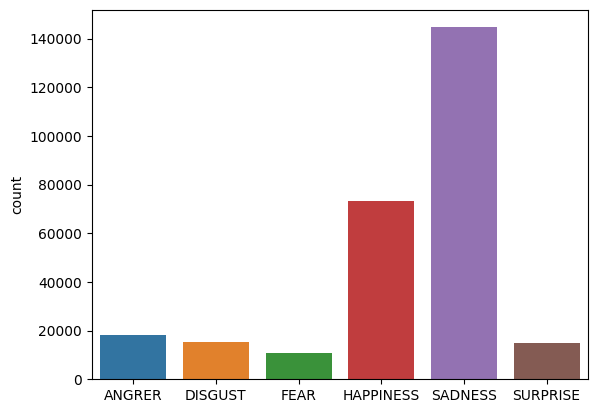

<Figure size 1200x800 with 0 Axes>

In [11]:
import seaborn as sns

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
class_to_idx=test_dataset.class_to_idx
print(class_to_idx)
idx_to_class={idx:cls for cls,idx in class_to_idx.items()}
print(idx_to_class)

images = train_dataset.targets
labels = list(images)
for image in range(len(images)):
    labels[image] = (idx_to_class.get(images[image]))
    
    
classes = ('ANGRER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE')
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
distr_plot = sns.countplot(x = labels)
plt.figure(figsize = (12,8))


                                           
plt.show()

In [12]:
kwargs = {'num_workers': 2, 'pin_memory': False} if use_cuda else {}

print(train_dir,test_dir)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
#cw/=cw.min()
cw*=counts.mean()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
array_weights = np.array(list(class_weights.values()), dtype=float)
tensor_weights = torch.from_numpy(array_weights)
print(counts, class_weights.values(), tensor_weights)

#split to train val
train_size = int(0.75 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print('split to train\val', len(train_dataset), len(val_dataset))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)



test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

training_set_synthetic_images/training_set_synthetic_images validation_set_real_images/validation_set_real_images
[ 18286  15150  10923  73285 144631  14976] dict_values([2.5269878595646946, 3.0500660066006597, 4.230385425249474, 0.6305314866616634, 0.31949236332459846, 3.0855034722222223]) tensor([2.5270, 3.0501, 4.2304, 0.6305, 0.3195, 3.0855], dtype=torch.float64)
split to trainal 207938 69313
207938 4670


In [ ]:
array_weights

array([2.52698786, 3.05006601, 4.23038543, 0.63053149, 0.31949236,
       3.08550347])

In [ ]:
class_to_idx=test_dataset.class_to_idx
print(class_to_idx)
idx_to_class={idx:cls for cls,idx in class_to_idx.items()}
print(idx_to_class)

{'ANGRER': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPINESS': 3, 'SADNESS': 4, 'SURPRISE': 5}
{0: 'ANGRER', 1: 'DISGUST', 2: 'FEAR', 3: 'HAPPINESS', 4: 'SADNESS', 5: 'SURPRISE'}


In [ ]:
#num_classes=len(train_dataset.classes)
#print(num_classes)

## Importing pretrained model

In [ ]:
from torchvision.models import resnet18
from torchvision.models import efficientnet_b0
from torchmetrics.functional import accuracy
from torchmetrics.classification import MulticlassF1Score
from lightning import LightningModule

#model = resnet18(pretrained=True)


class lsdResnet(LightningModule):
  def __init__(self, pretrained: bool = True, weights = None) -> None:
        super().__init__()
        self.pretrained = pretrained
        self.weights = weights

        if pretrained:
            #self.model = resnet18(pretrained=True)
            #self.model = facenet_pytorch.InceptionResnetV1(pretrained='vggface2')
            self.model = efficientnet_b0(pretrained=True)

            self.model.fc = nn.Identity()
            self.classifier = nn.Sequential(
                nn.BatchNorm1d(1000),
                nn.LeakyReLU(),
                nn.Linear(1000, 256), 
                nn.LeakyReLU(),
                nn.Linear(256, 64), 
                nn.Dropout(p=0.3),
                nn.LeakyReLU(),
                nn.Linear(64, 6)
            )
            #self.optimizer = torch.optim.Adam(self.classifier.parameters())
        else:
            self.model = resnet18(pretrained=False)
            self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss(weight=weights)

  def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            preds = self.model(x)
        return preds

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr = 4e-3)
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size  = 10 , gamma = 0.65)
        #learning rate scheduler
        return {
            "optimizer":optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train_loss",
                
            }
        }

  def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        #self.log("F1Average", MulticlassF1Score(num_classes=6, average='micro').to(device))
        #print("F1Average", F1Average(preds, target))
        return loss

  def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        #accuracy(task="multiclass", num_classes=6)
        F1Average = MulticlassF1Score(num_classes=6, average='micro').to(device)
        F1Average(preds, target)
        self.log("val_loss", loss, prog_bar=True)
        #self.log("F1Average", F1Average, prog_bar=True)
        #self.log("F1Average", MulticlassF1Score(num_classes=6, average='micro').to(device))

        print("F1Average on val", F1Average(preds, target))

  def test_step(self, test_batch, batch_idx) -> None:
        images, target = test_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        #accuracy(task="multiclass", num_classes=6)
        F1Average = MulticlassF1Score(num_classes=6, average='micro').to(device)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("F1Average", F1Average(preds, target), prog_bar=True)
        print("F1Average on test", F1Average(preds, target))

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping



lsdModel = lsdResnet(pretrained=True, weights = tensor_weights.float())

trainer = pl.Trainer(accelerator = "gpu", max_epochs = 5
                     , callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience = 3)]
                     )
trainer.fit(lsdModel, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type             | Params
------------------------------------------------
0 | model      | EfficientNet     | 5.3 M 
1 | classifier | Sequential       | 275 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.255    T

Sanity Checking: 0it [00:00, ?it/s]

F1Average on val tensor(0.0156, device='cuda:0')
F1Average on val tensor(0.0625, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.6562, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8125, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.7812, device='cuda:0')
F1Average on val tensor(0.8125, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8125, device='cuda:0')
F1Average on val tensor(0.7812, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8125, device='cuda:0')
F1Average on val ten

Validation: 0it [00:00, ?it/s]

F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.7500, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.7344, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.7344, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.7500, device='cuda:0')
F1Average on val ten

Validation: 0it [00:00, ?it/s]

F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.7656, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.7500, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val ten

Validation: 0it [00:00, ?it/s]

F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.9375, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.7969, device='cuda:0')
F1Average on val tensor(0.8906, device='cuda:0')
F1Average on val ten

Validation: 0it [00:00, ?it/s]

F1Average on val tensor(0.8125, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.9375, device='cuda:0')
F1Average on val tensor(0.8438, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.9375, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8281, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.9062, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val tensor(0.8750, device='cuda:0')
F1Average on val tensor(0.9219, device='cuda:0')
F1Average on val tensor(0.9375, device='cuda:0')
F1Average on val tensor(0.8594, device='cuda:0')
F1Average on val ten

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(lsdModel, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

F1Average on test tensor(0.5000, device='cuda:0')
F1Average on test tensor(0.7500, device='cuda:0')
F1Average on test tensor(0.7969, device='cuda:0')
F1Average on test tensor(0.7656, device='cuda:0')
F1Average on test tensor(0.6719, device='cuda:0')
F1Average on test tensor(0.6406, device='cuda:0')
F1Average on test tensor(0.7812, device='cuda:0')
F1Average on test tensor(0.7500, device='cuda:0')
F1Average on test tensor(0.6406, device='cuda:0')
F1Average on test tensor(0.7031, device='cuda:0')
F1Average on test tensor(0.8906, device='cuda:0')
F1Average on test tensor(0.8438, device='cuda:0')
F1Average on test tensor(0.7031, device='cuda:0')
F1Average on test tensor(0.9375, device='cuda:0')
F1Average on test tensor(0.9531, device='cuda:0')
F1Average on test tensor(0.8906, device='cuda:0')
F1Average on test tensor(0.7188, device='cuda:0')
F1Average on test tensor(0.5156, device='cuda:0')
F1Average on test tensor(0.8125, device='cuda:0')
F1Average on test tensor(0.8594, device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         F1Average         │    0.6856530904769897     │
│         test_loss         │    1.1319642066955566     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1319642066955566, 'F1Average': 0.6856530904769897}]

In [ ]:
model_scripted = torch.jit.script(lsdModel) # Export to TorchScript
model_scripted.save('/content/model.pt')





# Testing model on 1 picture


In [ ]:
#upload a .pt model

#files.upload()

image = Image.open("/content/validation_set_real_images/validation_set_real_images/SADNESS/000001.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = preprocess(image).unsqueeze(0)

modelTest = torch.load("/content/lsdModel5EpochsLeakyReluHead.pt")

modelTest.eval()

output = modelTest(image_tensor)
print(idx_to_class.get(output.data.cpu().numpy().argmax()))

/usr/local/lib/python3.9/dist-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


SADNESS


### Test results

In [13]:
 #Import Model
lsdModel = torch.jit.load('server/model.pt')
lsdModel.eval()

RecursiveScriptModule(
  original_name=lsdResnet
  (model): RecursiveScriptModule(
    original_name=EfficientNet
    (features): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Conv2dNormActivation
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=SiLU)
      )
      (1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=MBConv
          (block): RecursiveScriptModule(
            original_name=Sequential
            (0): RecursiveScriptModule(
              original_name=Conv2dNormActivation
              (0): RecursiveScriptModule(original_name=Conv2d)
              (1): RecursiveScriptModule(original_name=BatchNorm2d)
              (2): RecursiveScriptModule(original_name=SiLU)
            )
            (1): RecursiveScriptModule(
         

In [14]:
def test_accuracy(net, testloader):
    correct = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.max(outputs.data, 1)[1]

            correct += (predicted == labels).sum().item()
    
    return correct / len(testloader.dataset)
    
#modelTest.to(device)
def test_accuracy_per_class(net, testloader, device):
    trainset = testloader.dataset
    correct_pred = {classname: 0 for classname in trainset.classes}
    total_pred = {classname: 0 for classname in trainset.classes}

    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images).to(device)
            predicted = torch.max(outputs.data, 1)[1]

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[trainset.classes[label]] += 1
                total_pred[trainset.classes[label]] += 1
    
    accuracy_per_class = {classname: 0 for classname in trainset.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

overall_accuracy = test_accuracy(lsdModel, test_loader)

print(
    'Overall accuracy of the network  '
    f'{(overall_accuracy * 100):.2f} %\n'
    'on the 10000 test images'
)

accuracy_per_class = test_accuracy_per_class(lsdModel, test_loader, device)

print('Accuracy per class\n')
for classname, accuracy in accuracy_per_class.items():
    print(f'{classname:12s} {accuracy:.2f} %')

Overall accuracy of the network  68.33 %
on the 10000 test images
Accuracy per class

ANGRER       73.51 %
DISGUST      92.46 %
FEAR         63.48 %
HAPPINESS    60.74 %
SADNESS      66.67 %
SURPRISE     79.27 %


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = lsdModel(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


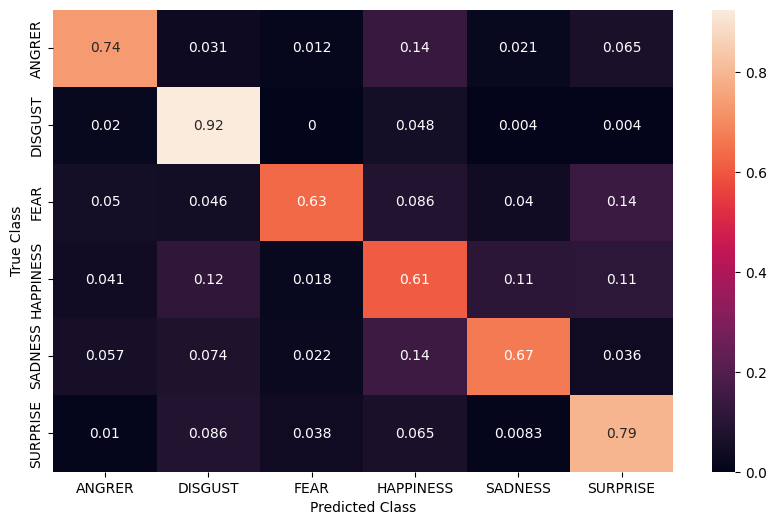

In [16]:
# constant for classes
classes = ('ANGRER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None]
                     , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,6))
ax = sn.heatmap(df_cm, annot=True, linewidth=0)
ax.set(xlabel="Predicted Class", ylabel="True Class")

plt.savefig('output.png')